# Subcellular location classification model via XGBoost

## Import package

In [13]:
from Bio import SeqIO
from Bio.SeqUtils import ProtParam

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

## Loading, Preprocessing and Feature engineering

In [7]:
#Read data
def nls_flag(seq):
    nls = 0
    for signal in nls_sig_list:
        nls += seq.count(signal)
    if nls > 0:
        return 1
    return 0

def read_fasta(filenames):
    target = filenames.split('.')[0]
    seq_id = []
    seq = []
    len_seq = []
    mole_weight = []
    aromatic = []
    inst_idx = []
    hydro = []
    iso_elec = []
    sec_str_frac_1 = []
    sec_str_frac_2 = []
    sec_str_frac_3 = []
    nls_f = []
    
    f_seq = []
    f_mole_weight = []
    f_aromatic = []
    f_inst_idx = []
    f_hydro = []
    f_iso_elec = []
    f_sec_str_frac_1 = []
    f_sec_str_frac_2 = []
    f_sec_str_frac_3 = []
    
    l_seq = []
    l_mole_weight = []
    l_aromatic = []
    l_inst_idx = []
    l_hydro = []
    l_iso_elec = []
    l_sec_str_frac_1 = []
    l_sec_str_frac_2 = []
    l_sec_str_frac_3 = []
    
    for seq_record in SeqIO.parse(filenames, "fasta"):
        seq_id.append(seq_record.id)
        
        prep_seq = str(seq_record.seq)
        prep_seq = prep_seq.replace("X", "")
        prep_seq = prep_seq.replace("U", "C")
        prep_seq = prep_seq.replace("B", "N")
        prep_seq = prep_seq.replace('Z', 'Q')
        
        seq.append(prep_seq)
        len_seq.append(len(seq_record))
        temp = ProtParam.ProteinAnalysis(prep_seq) 
        
        mole_weight.append(temp.molecular_weight())
        aromatic.append(temp.aromaticity())
        inst_idx.append(temp.instability_index())
        hydro.append(temp.gravy())
        iso_elec.append(temp.isoelectric_point())
        sec_str_frac_1.append(temp.secondary_structure_fraction()[0])
        sec_str_frac_2.append(temp.secondary_structure_fraction()[1])
        sec_str_frac_3.append(temp.secondary_structure_fraction()[2])
        nls_f.append(nls_flag(prep_seq))
        
        temp_f_seq = prep_seq[0:50]
        f_seq.append(temp_f_seq)
        temp = ProtParam.ProteinAnalysis(temp_f_seq)

        f_mole_weight.append(temp.molecular_weight())
        f_aromatic.append(temp.aromaticity())
        f_inst_idx.append(temp.instability_index())
        f_hydro.append(temp.gravy())
        f_iso_elec.append(temp.isoelectric_point())
        f_sec_str_frac_1.append(temp.secondary_structure_fraction()[0])
        f_sec_str_frac_2.append(temp.secondary_structure_fraction()[1])
        f_sec_str_frac_3.append(temp.secondary_structure_fraction()[2])
        
        temp_l_seq = prep_seq[-50:]
        l_seq.append(temp_l_seq)
        temp = ProtParam.ProteinAnalysis(temp_l_seq)
 
        l_mole_weight.append(temp.molecular_weight())
        l_aromatic.append(temp.aromaticity())
        l_inst_idx.append(temp.instability_index())
        l_hydro.append(temp.gravy())
        l_iso_elec.append(temp.isoelectric_point())
        l_sec_str_frac_1.append(temp.secondary_structure_fraction()[0])
        l_sec_str_frac_2.append(temp.secondary_structure_fraction()[1])
        l_sec_str_frac_3.append(temp.secondary_structure_fraction()[2])

    df = pd.DataFrame({ 'seq' : seq, 'len_seq' : len_seq, 
                       'mole_weight' : mole_weight,
                       'aromatic' : aromatic, 'inst_idx' : inst_idx, 'hydro' : hydro,
                       'iso_elec' : iso_elec,
                       'sec_str_frac_1' : sec_str_frac_1, 'sec_str_frac_2' : sec_str_frac_2,
                       'sec_str_frac_3' : sec_str_frac_3, 'nls_f' : nls_f,
                       
                       'f_seq' : f_seq, 'f_mole_weight' : f_mole_weight,
                       'f_aromatic' : f_aromatic, 'f_inst_idx' : f_inst_idx, 'f_hydro' : f_hydro,
                       'f_iso_elec' : f_iso_elec,
                       'f_sec_str_frac_1' : f_sec_str_frac_1, 'f_sec_str_frac_2' : f_sec_str_frac_2,
                       'f_sec_str_frac_3' : f_sec_str_frac_3,
                       
                       'l_seq' : l_seq, 'l_mole_weight' : l_mole_weight,
                       'l_aromatic' : l_aromatic, 'l_inst_idx' : l_inst_idx, 'l_hydro' : l_hydro,
                       'l_iso_elec' : l_iso_elec,
                       'l_sec_str_frac_1' : l_sec_str_frac_1, 'l_sec_str_frac_2' : l_sec_str_frac_2,
                       'l_sec_str_frac_3' : l_sec_str_frac_3
                      },index = seq_id)
    df['y'] = target
    return df

def data_pipeline(dat):
    for a in amino_dic:
        dat['num_' + a] = dat['seq'].str.count(a)
        dat['p_' + a] = dat['seq'].str.count(a)/dat['len_seq']
        dat['f_num_' + a] = dat['f_seq'].str.count(a)
        dat['f_p_' + a] = dat['f_seq'].str.count(a)/50
        dat['l_num_' + a] = dat['l_seq'].str.count(a)
        dat['l_p_' + a] = dat['l_seq'].str.count(a)/50
    for di in di_dic:
        dat['num_' + di] = dat['seq'].str.count(di)
        dat['f_num_' + di] = dat['f_seq'].str.count(di)
        dat['l_num_' + di] = dat['f_seq'].str.count(di)
    X = dat
    X = X.drop(['y','seq', 'f_seq', 'l_seq'], axis = 1)
    Y = dat['y']
    return X, Y

In [8]:
nls_db = pd.read_csv('nuclear.csv')
nls_sig_list = nls_db['Sequence']

cyto = read_fasta('cyto.fasta')
mito = read_fasta('mito.fasta')
nucleus = read_fasta('nucleus.fasta')
secreted = read_fasta('secreted.fasta')

df = pd.concat([cyto, mito, nucleus, secreted])

amino_dic = ['I','L','V','F','M','C','A','G','P','T','S','Y','W','Q','N','H','E','D','K','R']
di_dic = ['II','IL','IV','IF','IM','IC','IA','IG','IP','IT','IS','IY','IW','IQ','IN','IH','IE','ID','IK','IR',
          'LI','LL','LV','LF','LM','LC','LA','LG','LP','LT','LS','LY','LW','LQ','LN','LH','LE','LD','LK','LR',
          'VI','VL','VV','VF','VM','VC','VA','VG','VP','VT','VS','VY','VW','VQ','VN','VH','VE','VD','VK','VR',
          'FI','FL','FV','FF','FM','FC','FA','FG','FP','FT','FS','FY','FW','FQ','FN','FH','FE','FD','FK','FR',
          'MI','ML','MV','MF','MM','MC','MA','MG','MP','MT','MS','MY','MW','MQ','MN','MH','ME','MD','MK','MR',
          'CI','CL','CV','CF','CM','CC','CA','CG','CP','CT','CS','CY','CW','CQ','CN','CH','CE','CD','CK','CR',
          'AI','AL','AV','AF','AM','AC','AA','AG','AP','AT','AS','AY','AW','AQ','AN','AH','AE','AD','AK','AR',
          'GI','GL','GV','GF','GM','GC','GA','GG','GP','GT','GS','GY','GW','GQ','GN','GH','GE','GD','GK','GR',
          'PI','PL','PV','PF','PM','PC','PA','PG','PP','PT','PS','PY','PW','PQ','PN','PH','PE','PD','PK','PR',
          'TI','TL','TV','TF','TM','TC','TA','TG','TP','TT','TS','TY','TW','TQ','TN','TH','TE','TD','TK','TR',
          'SI','SL','SV','SF','SM','SC','SA','SG','SP','ST','SS','SY','SW','SQ','SN','SH','SE','SD','SK','SR',
          'YI','YL','YV','YF','YM','YC','YA','YG','YP','YT','YS','YY','YW','YQ','YN','YH','YE','YD','YK','YR',
          'WI','WL','WV','WF','WM','WC','WA','WG','WP','WT','WS','WY','WW','WQ','WN','WH','WE','WD','WK','WR',
          'QI','QL','QV','QF','QM','QC','QA','QG','QP','QT','QS','QY','QW','QQ','QN','QH','QE','QD','QK','QR',
          'NI','NL','NV','NF','NM','NC','NA','NG','NP','NT','NS','NY','NW','NQ','NN','NH','NE','ND','NK','NR',
          'HI','HL','HV','HF','HM','HC','HA','HG','HP','HT','HS','HY','HW','HQ','HN','HH','HE','HD','HK','HR',
          'EI','EL','EV','EF','EM','EC','EA','EG','EP','ET','ES','EY','EW','EQ','EN','EH','EE','ED','EK','ER',
          'DI','DL','DV','DF','DM','DC','DA','DG','DP','DT','DS','DY','DW','DQ','DN','DH','DE','DD','DK','DR',
          'KI','KL','KV','KF','KM','KC','KA','KG','KP','KT','KS','KY','KW','KQ','KN','KH','KE','KD','KK','KR',
          'RI','RL','RV','RF','RM','RC','RA','RG','RP','RT','RS','RY','RW','RQ','RN','RH','RE','RD','RK','RR']

In [9]:
X, Y = data_pipeline(df)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## Training and Tuning Model

In [ ]:
# #Random Search Cross validation
# clf = xgb.XGBClassifier()

# param_grid = {
#         'silent': [False],
#         'max_depth': [5, 7, 10, 11, 12, 13, 14, 15],
#         'learning_rate': [0.001,0.01, 0.05, 0.1],
#         'subsample': [0.7, 0.8, 0.9],
#         'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#         'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#         'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0, 13.0],
#         'gamma': [0,0.1,0.2, 0.25, 0.5],
#         'n_estimators': [70, 100,400, 500, 1000],
#         'objective' : 'multi:softmax'}

In [ ]:
# fit_params_A = {'eval_metric': 'mlogloss',
#               'early_stopping_rounds': 10,
#               'eval_set': [(X_val, y_val)]}
# clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
#                             n_jobs=5, verbose=2, cv=5,
#                             fit_params=fit_params_A,
#                             random_state=42)
# #                             scoring='roc_auc')


# clf.fit(X_train, y_train)

In [ ]:
# best_score = clf.best_score_
# best_params = clf.best_params_
# print("Best score: {}".format(best_score))
# print("Best params: ")
# for param_name in sorted(best_params.keys()):
#     print('%s: %r' % (param_name, best_params[param_name]))

In [10]:
#Final Model
clf = xgb.XGBClassifier(colsample_bylevel =  0.9,
                        colsample_bytree= 0.6,
                        gamma= 0.5,
                        learning_rate= 0.1,
                        max_depth= 13,
                        min_child_weight= 10.0,
                        n_estimators= 500,
                        objective = 'multi:softmax',
                        silent= False,
                        subsample= 0.7,
                        random_state=42)
clf.fit(X_train, y_train,eval_metric = 'mlogloss',
              early_stopping_rounds = 10,
              eval_set = [(X_val, y_val)])

[0]	validation_0-mlogloss:1.28114
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.22941
[2]	validation_0-mlogloss:1.16639
[3]	validation_0-mlogloss:1.12241
[4]	validation_0-mlogloss:1.03875
[5]	validation_0-mlogloss:0.982308
[6]	validation_0-mlogloss:0.939814
[7]	validation_0-mlogloss:0.881886
[8]	validation_0-mlogloss:0.829037
[9]	validation_0-mlogloss:0.806533
[10]	validation_0-mlogloss:0.785745
[11]	validation_0-mlogloss:0.750394
[12]	validation_0-mlogloss:0.732626
[13]	validation_0-mlogloss:0.69561
[14]	validation_0-mlogloss:0.662731
[15]	validation_0-mlogloss:0.632221
[16]	validation_0-mlogloss:0.611295
[17]	validation_0-mlogloss:0.585987
[18]	validation_0-mlogloss:0.570915
[19]	validation_0-mlogloss:0.562522
[20]	validation_0-mlogloss:0.542617
[21]	validation_0-mlogloss:0.5231
[22]	validation_0-mlogloss:0.510219
[23]	validation_0-mlogloss:0.500749
[24]	validation_0-mlogloss:0.485303
[25]	validation_0-mlogloss:0.477496
[26]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=13, min_child_weight=10.0, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.7)

In [11]:
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of XGBoost classifier on test set: 0.89


/Users/lingpae/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Model Evaluation

/Users/lingpae/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[520  39  12  23]
 [ 64 181   0  10]
 [  6   0 652   0]
 [ 29  15   0 294]]


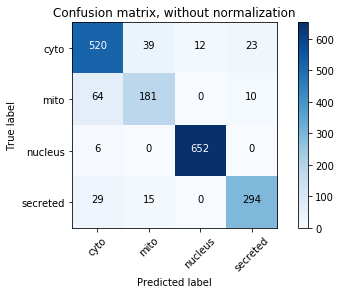

In [15]:
y_pred = clf.predict(X_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['cyto', 'mito', 'nucleus', 'secreted']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,  
             target_names= ['cyto','mito','nucleus','secreted']))

             precision    recall  f1-score   support

       cyto       0.84      0.88      0.86       594
       mito       0.77      0.71      0.74       255
    nucleus       0.98      0.99      0.99       658
   secreted       0.90      0.87      0.88       338

avg / total       0.89      0.89      0.89      1845



In [23]:
#Feature importance
trail = pd.DataFrame({'Feature_Importance' : clf.feature_importances_},index = X_train.columns.values)
trail.sort_values(by='Feature_Importance', ascending=False)[0:10]

,Feature_Importance
f_hydro,0.024629
nls_f,0.019024
f_iso_elec,0.018709
iso_elec,0.015867
p_C,0.014288
inst_idx,0.013656
p_L,0.012788
sec_str_frac_1,0.012393
sec_str_frac_3,0.011999
p_G,0.011288


# Prediction Section

In [24]:
blind = read_fasta('blind.fasta')
blind_X, _ = data_pipeline(blind)

In [26]:
pd.DataFrame({'Predict' : clf.predict(blind_X),
              'Confident' : np.max(clf.predict_proba(blind_X), axis = 1)
             },index=blind_X.index)

/Users/lingpae/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,Confident,Predict
SEQ677,0.607594,secreted
SEQ231,0.934938,secreted
SEQ871,0.585427,secreted
SEQ388,0.902295,cyto
SEQ122,0.766991,cyto
SEQ758,0.991734,cyto
SEQ333,0.802106,cyto
SEQ937,0.927126,cyto
SEQ351,0.872970,cyto
SEQ202,0.805122,mito
